In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)

physeq.Bulk = subset_taxa(physeq.Bulk, Rank1=="k__Fungi")

physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq/ITS//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2247 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2247 taxa by 7 taxonomic ranks ]


In [5]:
%%R
climate = read.csv('../515_806/Chazy-Climate.csv')

In [6]:
%%R
library(lubridate)
climate = filter(climate, !(is.na(Sample_date)))
climate$Month = months(as.Date(climate$Sample_date))
climate$Year = year(climate$Sample_date)
climate$MY = paste(climate$Month, climate$Year, sep = '-')

head(climate, n = 10)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘lubridate’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:IRanges’:

    %within%


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:plyr’:

    here


  res = super(Function, self).__call__(*new_args, **new_kwargs)


   Airport       Date Fog Rain Snow AvgTemp AvgVisibility MaxTemp MinTemp
1      PBG 1404540000   0    0    0      22            16      82      60
2      PBG 1404626400   0    0    0      22            16      84      59
3      PBG 1404712800   0    1    0      21            14      75      63
4      PBG 1404799200   1    1    0      23             8      84      61
5      PBG 1404885600   0    0    0      22            16      81      63
6      PBG 1404972000   0    0    0      18            16      76      53
7      PBG 1411106400   0    0    0       6            16      55      30
8      PBG 1411192800   0    0    0      12            16      69      36
9      PBG 1411279200   0    1    0      21            15      78      61
10     PBG 1411365600   0    1    0      11            16      63      39
   Precipitation Sample_date     Month Year             MY
1           0.00  2014-07-05      July 2014      July-2014
2           0.00  2014-07-06      July 2014      July-2014
3        

In [7]:
%%R
mean_Temp = climate %>% select(Sample_date, MY, AvgTemp) %>% group_by(MY) %>% mutate(min = dense_rank(AvgTemp)) %>% 
            #filter((min != min(min))) %>% 
            summarise(mean_mean = mean(AvgTemp)) 

mean_Temp %>% as.data.frame

               MY  mean_mean
1      April-2015  8.5000000
2     August-2015 19.3333333
3       July-2014 21.3333333
4       July-2015 21.3333333
5       June-2015 18.0000000
6   November-2014  3.5000000
7   November-2015  0.6666667
8    October-2014  9.3333333
9    October-2015  5.6666667
10 September-2014 12.6666667
11 September-2015 15.6666667


In [8]:
%%R
sample_data(physeq.Bulk)$MY = paste(sample_data(physeq.Bulk)$Month, sample_data(physeq.Bulk)$Year, sep = '-')
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.test = left_join(physeq.Bulk.m, mean_Temp, by = 'MY')


In [9]:
%%R
sample_data(physeq.Bulk)$Alt_temp = physeq.test$mean_mean

In [10]:
%%R
physeq.Bulk.m = physeq.Bulk %>% sample_data
head(physeq.Bulk.m)


Sample Data:        [6 samples by 26 sample variables]:
                  Full.sample Fraction PrimerF PrimerR Barcode Rev.index
April.NTR.4       April.NTR.4       NA  nBITSf   58A2r     155  atagtacc
Aug.NTR.3.2015 Aug.NTR.3.2015       NA  nBITSf   58A2r     129  gatctacg
April.PTR.3       April.PTR.3       NA  nBITSf   58A2r     150  acgtgcgc
July15.NTH.3     July15.NTH.3       NA  nBITSf   58A2r     184  aacgctga
Nov.NTR.1           Nov.NTR.1       NA  nBITSf   58A2r     125  tctctatg
June.NTH.2         June.NTH.2       NA  nBITSf   58A2r     162  gcgtatac
               Fwd.index Treatment Day Pool     Experiment Gradient
April.NTR.4     tagcgagt       NTR  NA    4 Chazy.ITS.Bulk     <NA>
Aug.NTR.3.2015  atcgtacg       NTR  NA    5 Chazy.ITS.Bulk     <NA>
April.PTR.3     cgtgagtg       PTR  NA    4 Chazy.ITS.Bulk     <NA>
July15.NTH.3    gacaccgt       NTH  NA    4 Chazy.ITS.Bulk     <NA>
Nov.NTR.1       tcatcgag       NTR  NA    4 Chazy.ITS.Bulk     <NA>
June.NTH.2      actatctg 

In [11]:
%%R
get_l2fc = function(physeq.obj, Till, sparsity_threshold) {
  
    physeq.Bulk.m = physeq.obj %>% sample_data

    p = prune_samples((physeq.Bulk.m$Till == Till),
                           physeq.Bulk)
   
    
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Alt_temp)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}
                    
                  

In [12]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Till) %>%
   distinct() %>%
    arrange(Till) 
  

sdm

  Till
1    N
2    P


In [13]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Till, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Till'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

Number of pairwise combinations of variables: 38 

  Till sparsity_threshold
1    N               0.05
2    P               0.05
3    N               0.10
4    P               0.10
5    N               0.15
6    P               0.15


In [14]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [7,365 x 13]

    Till sparsity_threshold       OTU log2FoldChange      lfcSE      padj
   (chr)              (dbl)     (chr)          (dbl)      (dbl)     (dbl)
1      N               0.05  OTU.6089    0.010408183 0.05597552 0.9713070
2      N               0.05  OTU.2605   -0.068446472 0.05440722 0.7067131
3      N               0.05 OTU.14908    0.121318021 0.06296859 0.3499398
4      N               0.05  OTU.6041    0.048921292 0.06202453 0.8697316
5      N               0.05  OTU.6291    0.011771344 0.05906773 0.9713070
6      N               0.05  OTU.9364   -0.060264583 0.05108248 0.7379030
7      N               0.05   OTU.586    0.034483236 0.04950452 0.8762785
8      N               0.05 OTU.19007    0.063353059 0.06297975 0.8216634
9      N               0.05   OTU.469   -0.017915712 0.05948832 0.9674719
10     N               0.05  OTU.1470   -0.003365792 0.04045947 0.9829152
..   ...                ...       ...            ...        ...       ...

In [15]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

     meanl2fc
        (dbl)
1 -0.01420174


In [16]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

      sdl2fc
       (dbl)
1 0.05918159


In [17]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [18]:
%%R
df.l2fc$Temp[df.l2fc$log2FoldChange > 0] = "increasing"
df.l2fc$Temp[df.l2fc$log2FoldChange <0] = "decreasing"

In [19]:
%%R
write.table(df.l2fc, "data/l2fc_TempCompiled_allsamp", row.names = FALSE, sep = ",")

In [20]:
%%R
df.l2fc = read.table('data/l2fc_TempCompiled_allsamp', sep =',', header = TRUE)

In [21]:
%%R
head(df.l2fc)

  Till sparsity_threshold       OTU log2FoldChange      lfcSE      padj
1    N               0.05  OTU.6089     0.01040818 0.05597552 0.9713070
2    N               0.05  OTU.2605    -0.06844647 0.05440722 0.7067131
3    N               0.05 OTU.14908     0.12131802 0.06296859 0.3499398
4    N               0.05  OTU.6041     0.04892129 0.06202453 0.8697316
5    N               0.05  OTU.6291     0.01177134 0.05906773 0.9713070
6    N               0.05  OTU.9364    -0.06026458 0.05108248 0.7379030
     Rank1            Rank2             Rank3           Rank4           Rank5
1 k__Fungi  p__unidentified   c__unidentified o__unidentified f__unidentified
2 k__Fungi  p__unidentified   c__unidentified o__unidentified f__unidentified
3 k__Fungi p__Basidiomycota c__Agaricomycetes   o__Agaricales f__Bolbitiaceae
4 k__Fungi p__Basidiomycota c__Agaricomycetes   o__Agaricales  f__Agaricaceae
5 k__Fungi p__Basidiomycota c__Agaricomycetes   o__Agaricales  f__Agaricaceae
6 k__Fungi p__Basidiomycota 

In [22]:
%%R
r = filter(df.l2fc, padj2 <=0.10)
print(length(unique(r$OTU)))
print(length(df.l2fc$OTU))

[1] 39
[1] 7365


In [23]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold, Till) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>%  as.data.frame

   sparsity_threshold Till n_reject_hypo
1                0.05    N            29
2                0.05    P             4
3                0.10    N            32
4                0.10    P             5
5                0.15    N            33
6                0.15    P             5
7                0.20    N            30
8                0.20    P             4
9                0.25    N            27
10               0.25    P             4
11               0.30    N            23
12               0.30    P             4
13               0.35    N            20
14               0.35    P             3
15               0.40    N            15
16               0.40    P             3
17               0.45    N            12
18               0.45    P             3
19               0.50    N            10
20               0.50    P             2
21               0.55    N             7
22               0.55    P             1
23               0.60    N             6
24              

In [24]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.15


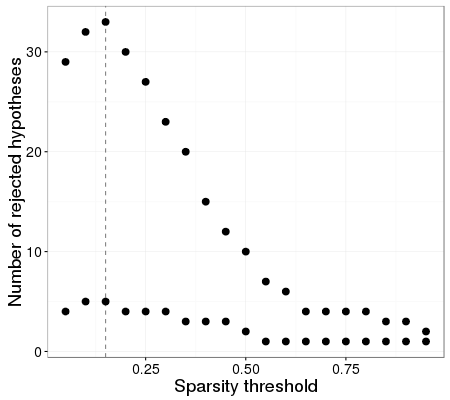

In [25]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [26]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == 0.10) 

df.l2fc.f %>% nrow

[1] 981


In [27]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_Temp_allSamples.txt'
write.table(df.l2fc.f, 'data/l2fc_Temp_allSamples.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [28]:
%%R
df.l2fc = read.table('data/l2fc_Temp_allSamples.txt', sep='\t', header = TRUE)

In [29]:
%%R
#df.l2fc = df.l2fc.f

df.l2fc$Rank2 = gsub("p__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("c__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("o__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("f__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("g__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("s__", "", df.l2fc$Rank7)

In [30]:
%%R
print(length(df.l2fc$OTU))
print(length(unique(df.l2fc$OTU)))

[1] 981
[1] 623


In [31]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Temp, Till) %>% summarise(resp = n())
resp %>% as.data.frame

        Temp Till resp
1 decreasing    N   31
2 decreasing    P    3
3 increasing    N    1
4 increasing    P    2


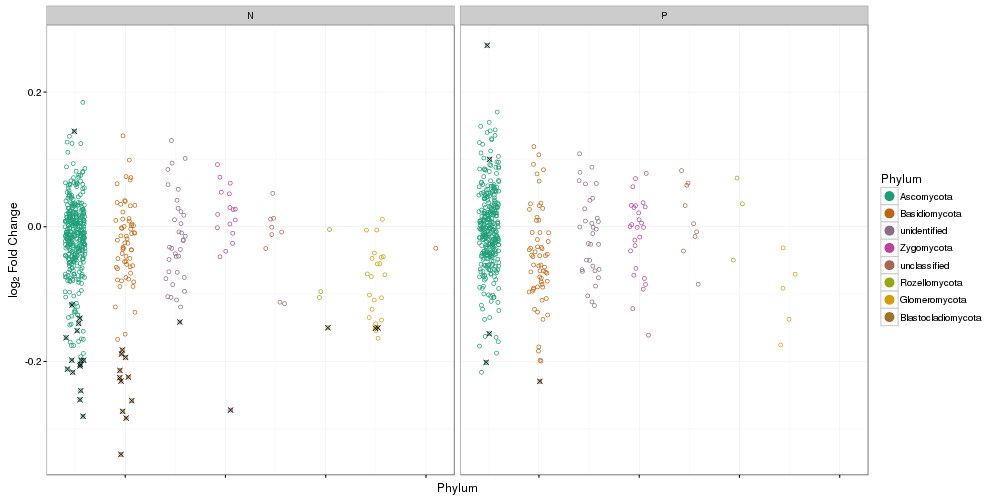

In [32]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(~Till)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4, shape = 19)))

p

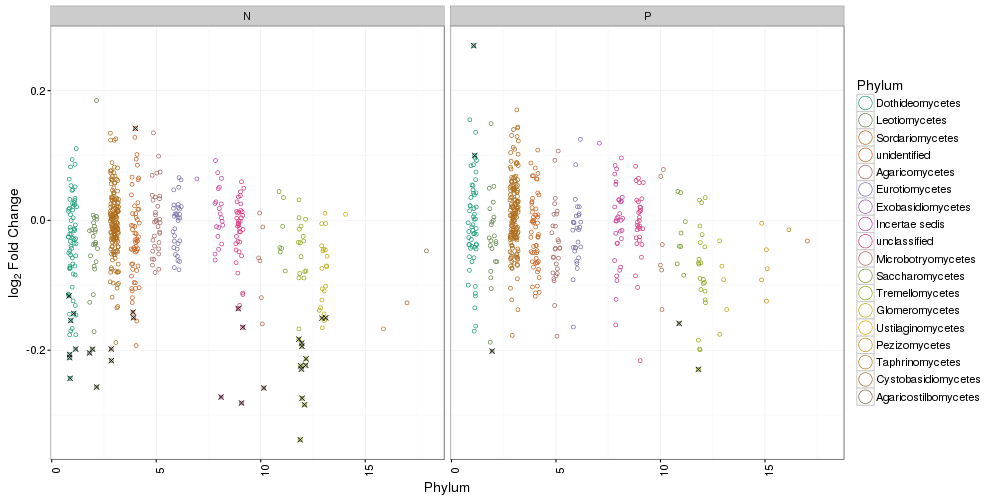

In [33]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank3 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))
p = p + facet_grid(~Till)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) 


p

In [34]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Temp, Till, Rank3) %>% summarise(resp = n())
resp %>% as.data.frame

         Temp Till              Rank3 resp
1  decreasing    N    Dothideomycetes    7
2  decreasing    N     Glomeromycetes    2
3  decreasing    N     Incertae sedis    1
4  decreasing    N      Leotiomycetes    3
5  decreasing    N Microbotryomycetes    1
6  decreasing    N    Sordariomycetes    2
7  decreasing    N    Tremellomycetes   10
8  decreasing    N       unidentified    2
9  decreasing    N               <NA>    3
10 decreasing    P      Leotiomycetes    1
11 decreasing    P    Saccharomycetes    1
12 decreasing    P    Tremellomycetes    1
13 increasing    N       unidentified    1
14 increasing    P    Dothideomycetes    2


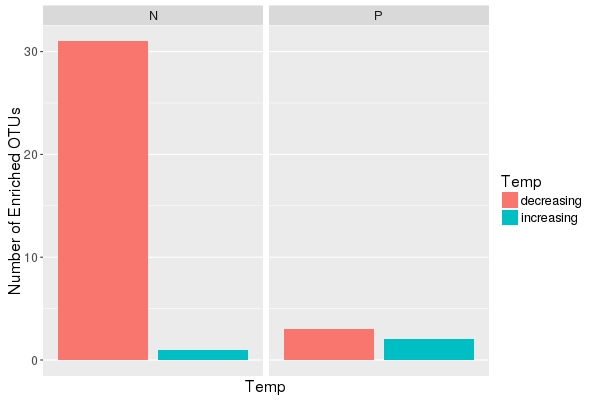

In [35]:
%%R -w 600 -h 400
p = ggplot(data = resp, aes(x = Temp, y = resp, fill = Temp)) +
    geom_bar(stat = 'identity') + facet_wrap(~Till) +
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") + scale_x_discrete(breaks=NULL)
p

In [36]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)

####Function arguments

In [37]:
%%R
colors.1 = c("#DA21B8",
"#86F84F",
"#B962F1",
"#7BCB03",
"#984BCF",
"#AFF13D",
"#BB1DB0",
"#4AB600",
"#EC60CF",
"#21B834",
"#AD0188",
"#BCD810",
"#2C4DB0",
"#98C815",
"#503B9E",
"#E1F957",
"#5A8DF8",
"#FD1300",
"#4EA6F4",
"#E93912",
"#68B5F3",
"#B4060B",
"#35D66F",
"#F82573",
"#73F28E",
"#FD1F54",
"#38C67A",
"#D02675",
"#A5F97D",
"#76328B",
"#98BE12",
"#9E88EB",
"#CEBF24",
"#3B3687",
"#E2A205",
"#2C73C3",
"#F7811F",
"#49AFDE",
"#D01C32",
"#0DC593",
"#F23D4F",
"#7DF5CB",
"#8D0506",
"#44C0AC",
"#F3643A",
"#09457F",
"#EDD65D",
"#DA92F0",
"#2AA142",
"#EB6CAD",
"#5F8F1A",
"#DF9ADA",
"#367220",
"#FF87A9",
"#22A470",
"#B12048",
"#C7F38C",
"#1D2151",
"#F0DE7C",
"#57265E",
"#EAF59D",
"#7D225C",
"#96E9B9",
"#F25E47",
"#1C739E",
"#B24E15",
"#DBF2FC",
"#4C1A07",
"#C4F4E7",
"#7C223D",
"#CEF7C5",
"#331B2D",
"#EEAA53",
"#1E3145",
"#FC966D",
"#0B2B05",
"#C4B0E7",
"#898E24",
"#F7D1E8",
"#2D3500",
"#F8847D",
"#114625",
"#F5AD9B",
"#205C39",
"#EDB374",
"#234F4A",
"#8F4918",
"#388C79",
"#796619",
"#513F0C",
"#5C6406",
"#93FB3B",
"#8C166F",
"#3CF397",
"#F63923",
"#2BFBD8",
"#B50F34",
"#7AF0EB",
"#D66E00",
"#579EFB",
"#A4CF32",
"#3E69C7",
"#E4F27B",
"#191D3B",
"#B2F8AB",
"#191D3B",
"#B2F8AB",
"#F15976",
"#38801A",
"#EE8BD6",
"#555415",
"#2F93C9",
"#EF8786",
"#142010",
"#F075AB",
"#0E4442",
"#F1B69C",
"#28507C",
"#CDCDE8")

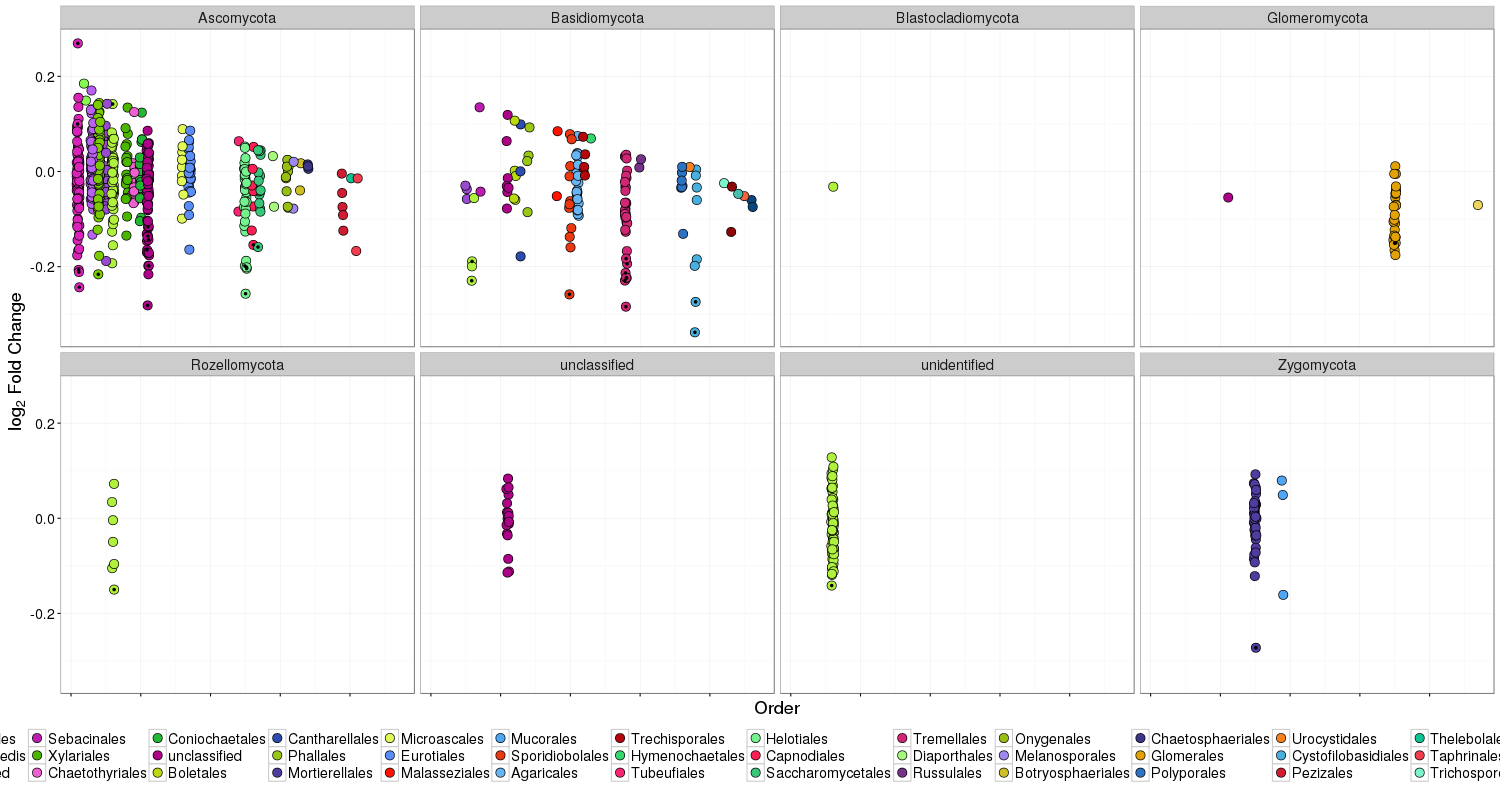

In [38]:
%%R -w 1500 -h 800
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(fill = guide_legend(nrow = 3))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=18)) #+ guides(color = FALSE)

p = p + facet_wrap(~Rank2, ncol = 4) +
    theme(legend.position = 'bottom')

p

In [39]:
%%R
head(df.l2fc)

  Till sparsity_threshold      OTU log2FoldChange      lfcSE      padj    Rank1
1    N                0.1 OTU.6089    0.010534883 0.05372235 0.9599513 k__Fungi
2    N                0.1 OTU.2605   -0.067564119 0.05258032 0.5830061 k__Fungi
3    N                0.1 OTU.6291    0.012204408 0.05611924 0.9599513 k__Fungi
4    N                0.1 OTU.9364   -0.059473284 0.04997287 0.6339503 k__Fungi
5    N                0.1  OTU.586    0.034200686 0.04858122 0.8186033 k__Fungi
6    N                0.1 OTU.1470   -0.003347886 0.04022314 0.9728021 k__Fungi
          Rank2           Rank3        Rank4        Rank5        Rank6    Rank7
1  unidentified    unidentified unidentified unidentified unidentified Fungi sp
2  unidentified    unidentified unidentified unidentified unidentified Fungi sp
3 Basidiomycota  Agaricomycetes   Agaricales  Agaricaceae   Lycoperdon     <NA>
4 Basidiomycota  Agaricomycetes    Boletales         <NA>         <NA>     <NA>
5    Ascomycota Dothideomycetes         

In [40]:
%%R
df.P = df.l2fc %>% group_by(Rank2) %>% mutate(ntax = n()) %>% filter(padj2 <= 0.10) %>% mutate(resp = n()) 
head(df.P)

Source: local data frame [6 x 17]
Groups: Rank2 [2]

    Till sparsity_threshold      OTU log2FoldChange      lfcSE         padj
  (fctr)              (dbl)   (fctr)          (dbl)      (dbl)        (dbl)
1      N                0.1  OTU.890      0.1418461 0.03833261 3.653058e-03
2      N                0.1 OTU.3927     -0.2740546 0.05526554 4.112482e-05
3      N                0.1 OTU.2624     -0.3379783 0.05221391 1.254159e-08
4      N                0.1 OTU.1001     -0.2066290 0.04238411 5.100782e-05
5      N                0.1   OTU.25     -0.1646830 0.02705275 1.197510e-07
6      N                0.1 OTU.6640     -0.2160553 0.05100247 5.934129e-04
Variables not shown: Rank1 (fctr), Rank2 (chr), Rank3 (chr), Rank4 (chr), Rank5
  (chr), Rank6 (chr), Rank7 (chr), padj2 (dbl), Temp (fctr), ntax (int), resp
  (int)


In [41]:
%%R
df.P2 = df.P %>% ungroup %>% select(Rank2, ntax, resp) %>% unique() 
df.P2$Perc_resp = df.P2$resp/df.P2$ntax

df.P2 %>% arrange(Rank2)

Source: local data frame [6 x 4]

          Rank2  ntax  resp  Perc_resp
          (chr) (int) (int)      (dbl)
1    Ascomycota   684    20 0.02923977
2 Basidiomycota   133    12 0.09022556
3 Glomeromycota    28     2 0.07142857
4 Rozellomycota     7     1 0.14285714
5  unidentified    67     1 0.01492537
6    Zygomycota    43     1 0.02325581


In [42]:
%%R
df.P2 = df.P %>% ungroup %>% select(Rank2, ntax, resp) %>% unique() 
df.P2$Perc_respoftotal = df.P2$resp/sum(df.P2$resp)

df.P2 %>% arrange(Rank2)

Source: local data frame [6 x 4]

          Rank2  ntax  resp Perc_respoftotal
          (chr) (int) (int)            (dbl)
1    Ascomycota   684    20       0.54054054
2 Basidiomycota   133    12       0.32432432
3 Glomeromycota    28     2       0.05405405
4 Rozellomycota     7     1       0.02702703
5  unidentified    67     1       0.02702703
6    Zygomycota    43     1       0.02702703


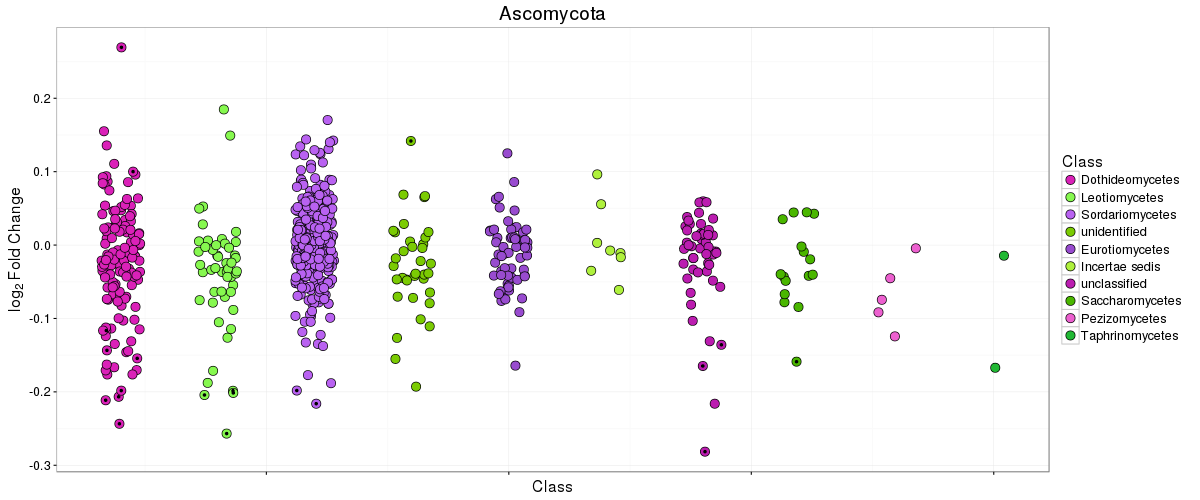

In [43]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

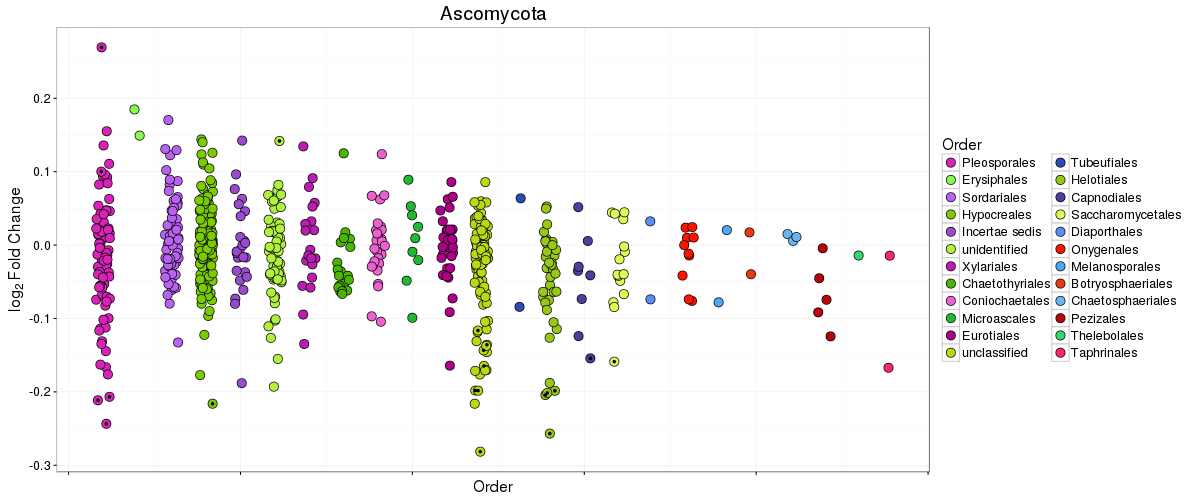

In [44]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

In [45]:
%%R
test = d %>% group_by(Rank4) %>% filter(padj2 <=0.10) %>% mutate(ntax = n()) %>% group_by(Rank4, Till, ntax) %>%
        summarise(resp = n()) 

test = test %>% select(Rank4, Till, resp, ntax)
test$total = (test$resp/test$ntax)
test %>% as.data.frame

              Rank4 Till resp ntax total
1      Pleosporales    N    3    5  0.60
2      Pleosporales    P    2    5  0.40
3       Hypocreales    N    1    1  1.00
4      unidentified    N    1    1  1.00
5      unclassified    N    7    7  1.00
6        Helotiales    N    3    4  0.75
7        Helotiales    P    1    4  0.25
8       Capnodiales    N    1    1  1.00
9 Saccharomycetales    P    1    1  1.00


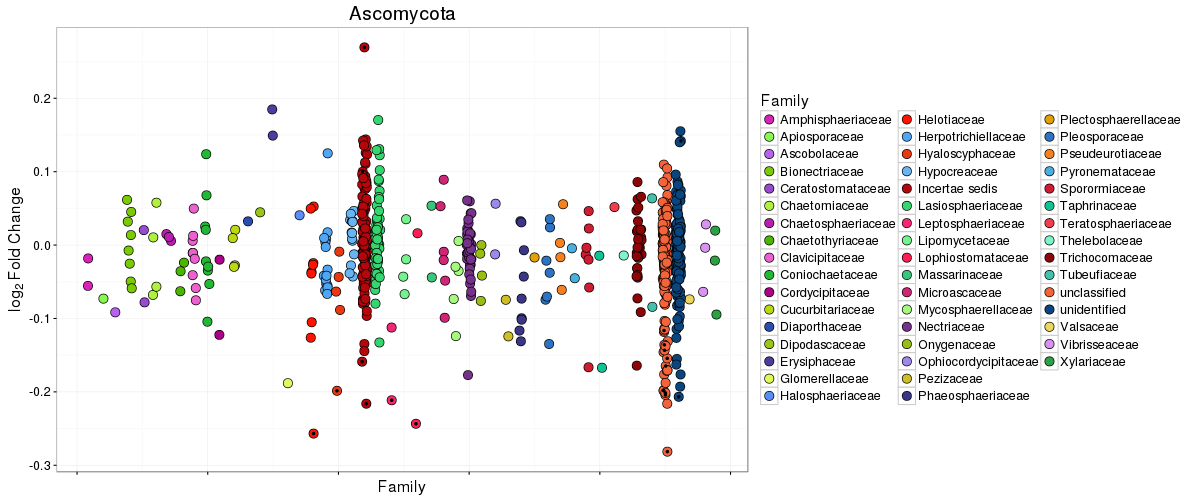

In [46]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank5 = as.character(d$Rank5)
d$Rank5[is.na(d$Rank5)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank5= factor(d$Rank5)

max.l2fc = ddply(d, .(Rank5), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank5, max.l2fc[order(-max.l2fc$M),]$Rank5)

M = max(as.numeric(d$Rank5), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank5)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank5))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Family", fill = "Family")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

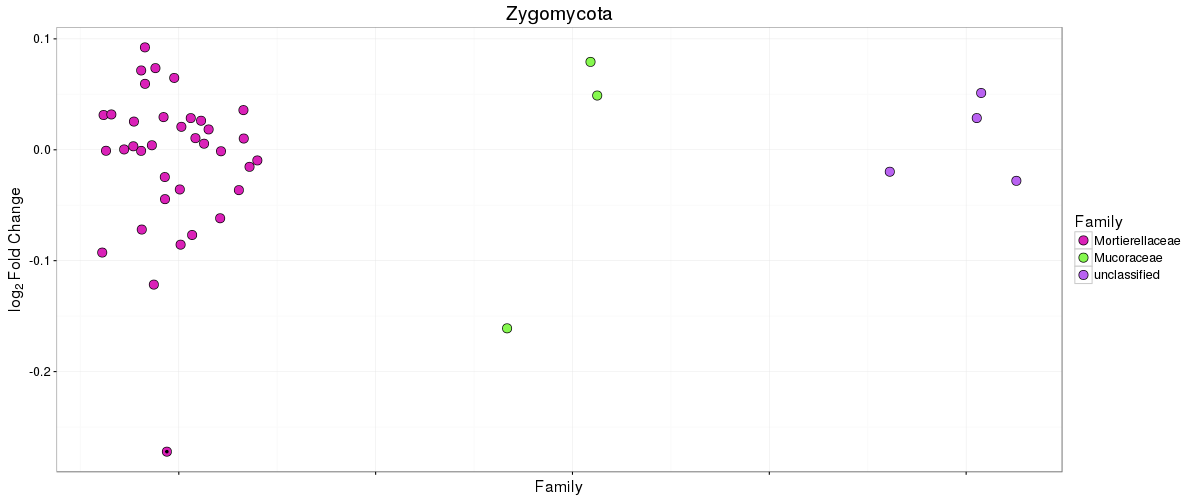

In [47]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Zygomycota')
d$Rank5 = as.character(d$Rank5)
d$Rank5[is.na(d$Rank5)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank5= factor(d$Rank5)

max.l2fc = ddply(d, .(Rank5), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank5, max.l2fc[order(-max.l2fc$M),]$Rank5)

M = max(as.numeric(d$Rank5), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank5)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank5))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Family", fill = "Family")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Zygomycota')


p

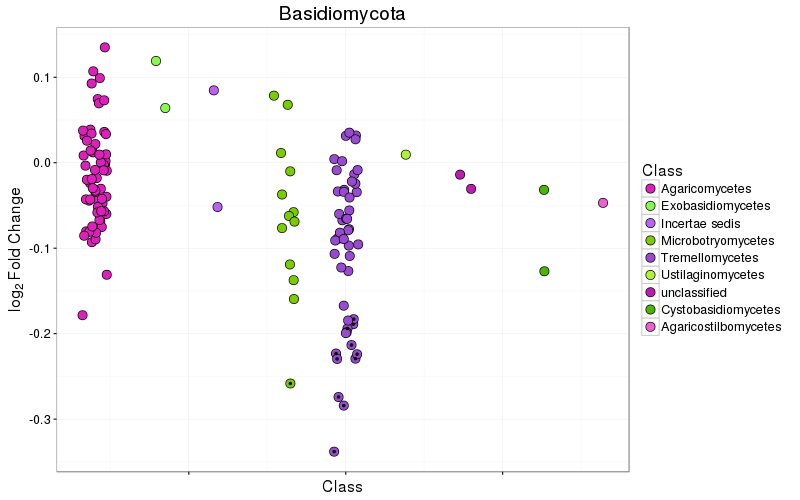

In [48]:
%%R -w 800 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Basidiomycota')
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Basidiomycota')


p

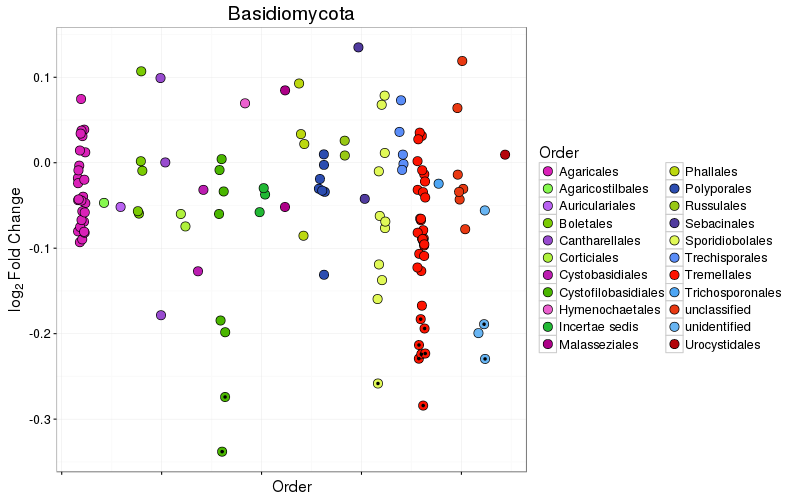

In [49]:
%%R -w 800 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Basidiomycota')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Basidiomycota')


p

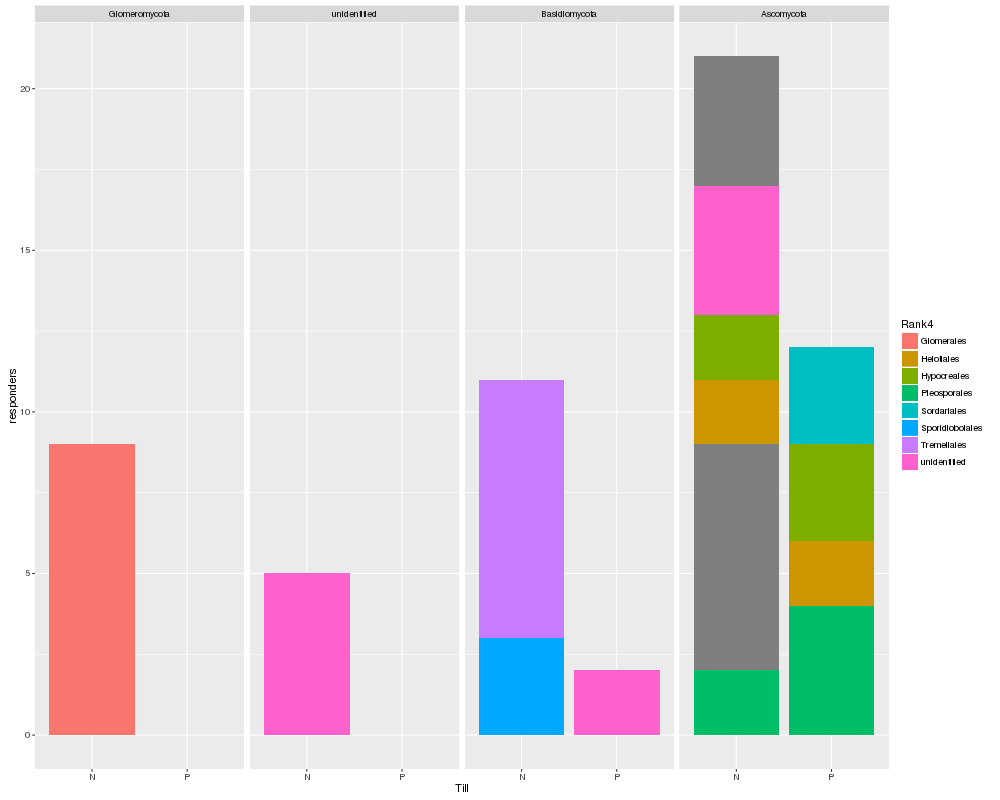

In [50]:
%%R -w 1000 -h 800
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          group_by(Rank2, Rank3, Rank4, Rank5, Till) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 1)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)


p = ggplot(dcounts, aes(x = Till , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") +
    facet_wrap( ~ Rank2, ncol = 4, nrow = 7) 

p

In [51]:
%%R
new_df.l2fc = df.l2fc
new_df.l2fc$Resp_status[new_df.l2fc$padj2 > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 & new_df.l2fc$log2FoldChange < 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 &  new_df.l2fc$log2FoldChange > 0] = "PT enriched"

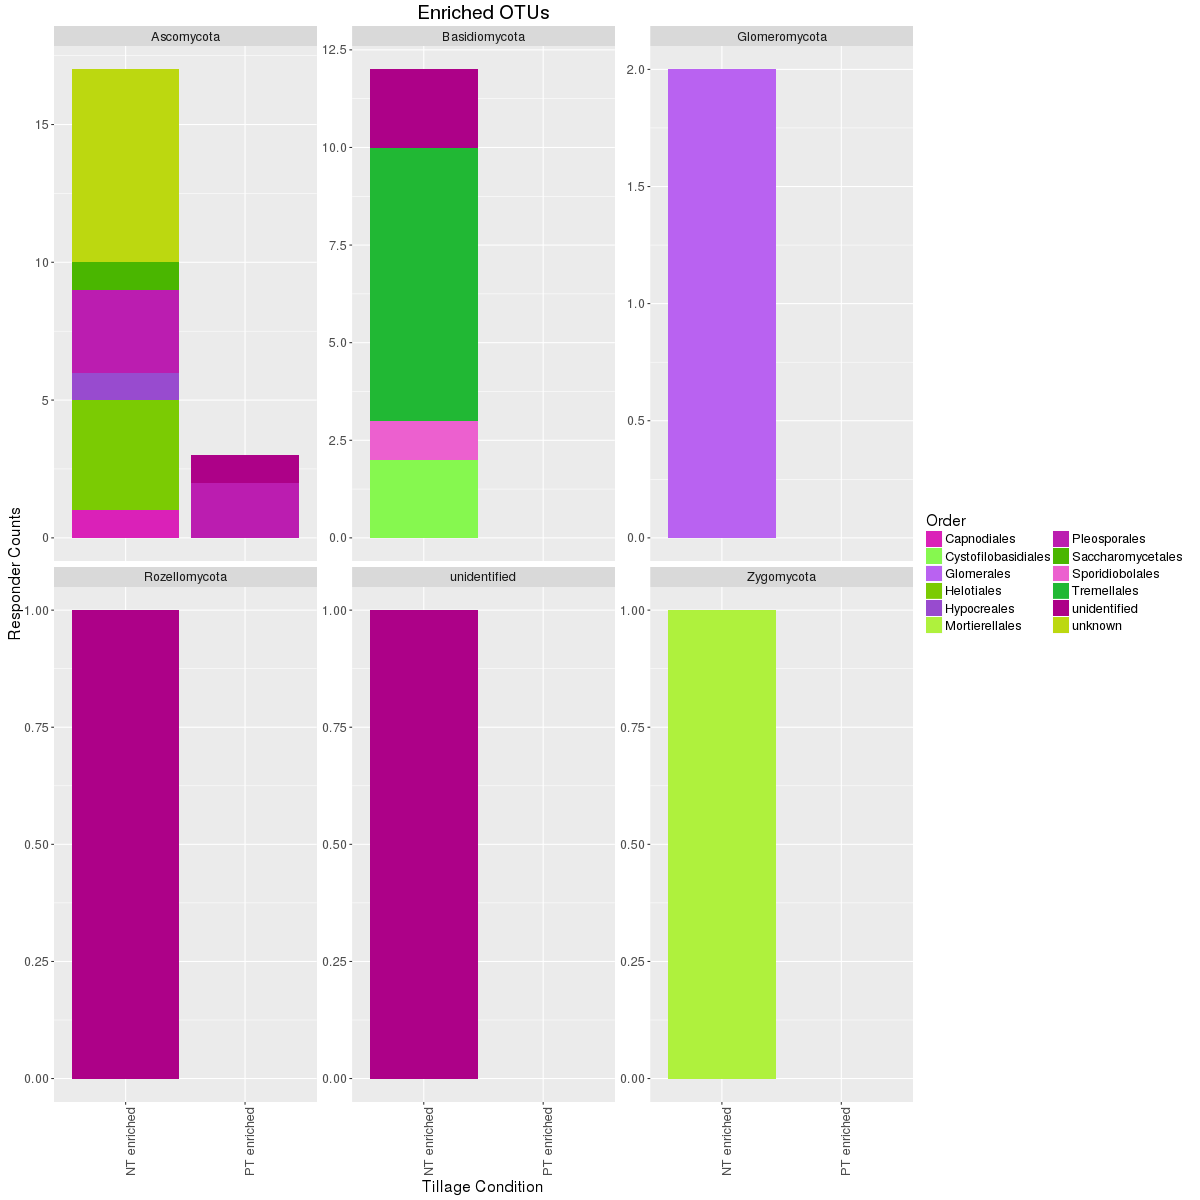

In [52]:
%%R -w 1200 -h 1200
dcounts = new_df.l2fc %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(OTU, Rank6, Rank5, Rank4, Rank3, Rank2, Resp_status) %>%
          summarize(responders = sum(padj2<= 0.10)) %>% ungroup() %>% arrange(Rank4)

dcounts$Rank4[is.na(dcounts$Rank4)] = "unknown"
dcounts$Rank5[is.na(dcounts$Rank5)] = "unknown"

dcounts$Rank4 = reorder(dcounts$Rank4, dcounts$Rank2)
#dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Tillage Condition") + guides(fill=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_fill_manual(values = colors.1)


p

In [53]:
%%R
dcounts%>% group_by(Rank4, Resp_status, Rank2) %>% select(Rank4, Rank2, responders, Resp_status) %>% 
                summarise(totresp = sum(responders)) %>% ungroup %>% arrange(Rank2) %>% as.data.frame

                 Rank4 Resp_status         Rank2 totresp
1          Capnodiales NT enriched    Ascomycota       1
2           Helotiales NT enriched    Ascomycota       4
3          Hypocreales NT enriched    Ascomycota       1
4         Pleosporales NT enriched    Ascomycota       3
5         Pleosporales PT enriched    Ascomycota       2
6    Saccharomycetales NT enriched    Ascomycota       1
7         unidentified PT enriched    Ascomycota       1
8              unknown NT enriched    Ascomycota       7
9  Cystofilobasidiales NT enriched Basidiomycota       2
10     Sporidiobolales NT enriched Basidiomycota       1
11         Tremellales NT enriched Basidiomycota       7
12        unidentified NT enriched Basidiomycota       2
13          Glomerales NT enriched Glomeromycota       2
14        unidentified NT enriched Rozellomycota       1
15        unidentified NT enriched  unidentified       1
16      Mortierellales NT enriched    Zygomycota       1


In [54]:
%%R
ggsave(filename = "data/figs/TillEnriched_byOrder.jpg", plot = p, width =20, height =14)

In [55]:
%%R
filter(dcounts, Rank2 == 'Cyanobacteria') %>% as.data.frame

[1] OTU         Rank6       Rank5       Rank4       Rank3       Rank2      
[7] Resp_status responders 
<0 rows> (or 0-length row.names)


In [56]:
%%R
length(unique(dcounts$Rank3))

[1] 10


In [57]:
%%R
colors = c("#F076F9",
"#3BF853",
"#8944B9",
"#93FB3B",
"#8C166F",
"#3CF397",
"#F63923",
"#2BFBD8",
"#B50F34",
"#7AF0EB",
"#D66E00",
"#579EFB",
"#A4CF32",
"#3E69C7",
"#E4F27B",
"#191D3B",
"#B2F8AB",
"#F15976",
"#38801A",
"#EE8BD6",
"#555415",
"#2F93C9",
"#EF8786",
"#142010",
"#F075AB",
"#0E4442",
"#F1B69C",
"#28507C",
"#CDCDE8")

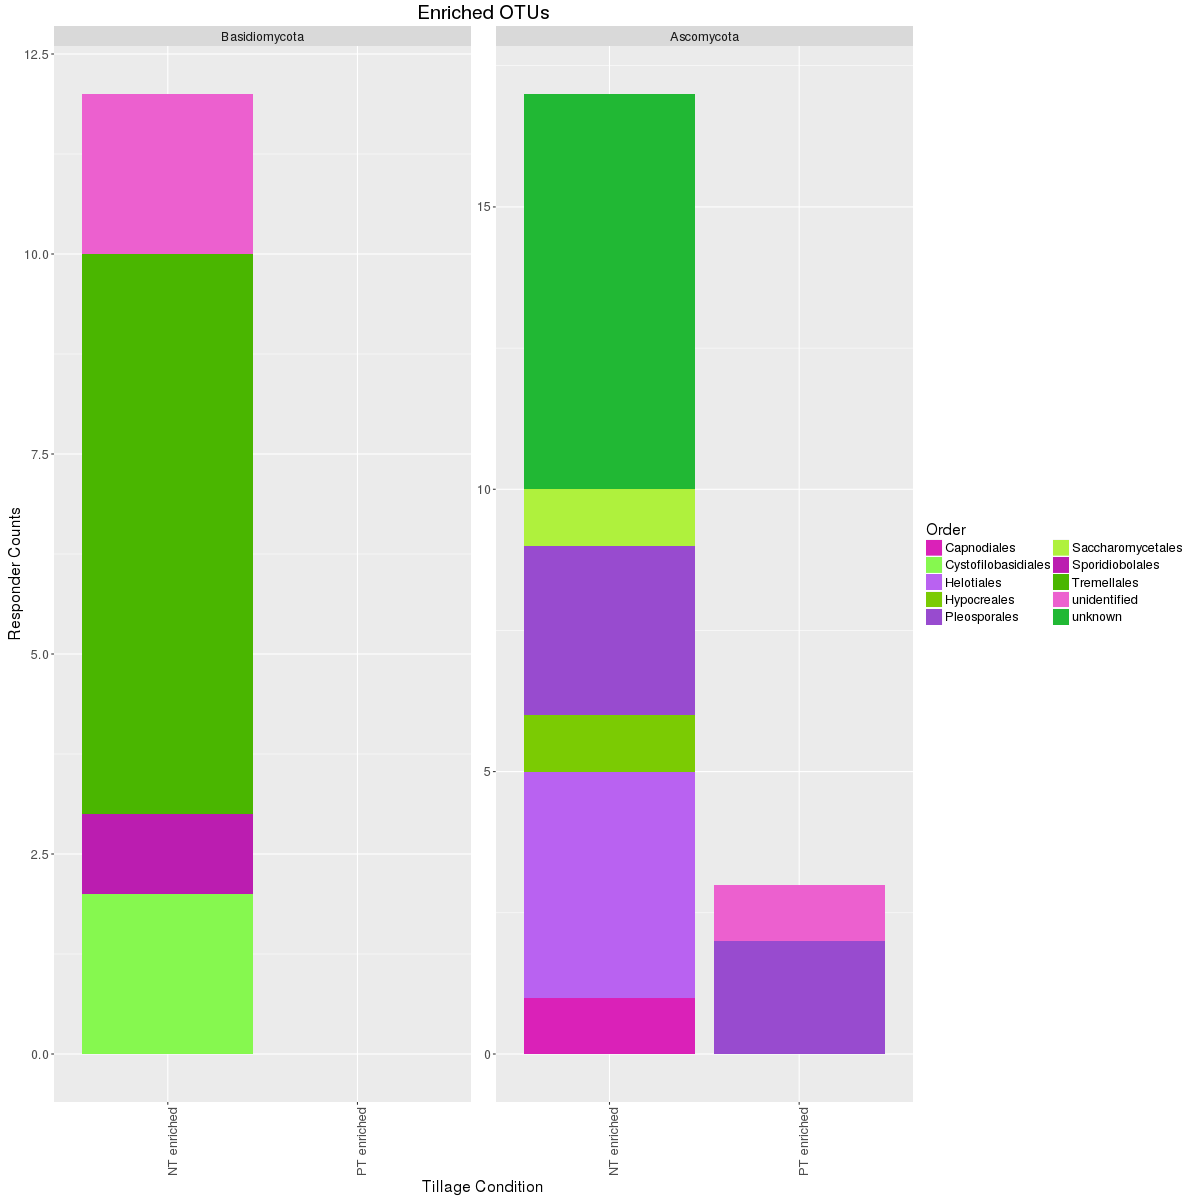

In [58]:
%%R -w 1200 -h 1200
Resp.to.keep = new_df.l2fc %>% group_by(Rank2, Resp_status) %>% summarise(Resp = sum(padj2<= 0.10)) %>% filter(Resp > 2)

dcounts.filt = filter(dcounts, Rank2 %in% Resp.to.keep$Rank2)

dcounts.filt$Rank3 = reorder(dcounts.filt$Rank3, -dcounts.filt$responders)
dcounts.filt$Rank2 = reorder(dcounts.filt$Rank2, -dcounts.filt$responders)


p = ggplot(dcounts.filt, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
   xlab("Tillage Condition") + guides(fill=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_fill_manual(values = colors.1)



p

In [59]:
%%R
ggsave(filename = "data/figs/TillEnriched_byOrder_filt.jpg", plot = p, width =20, height =14)

In [60]:
%%R
length(unique(d.counts.filt$Rank3))


Error in unique(d.counts.filt$Rank3) : object 'd.counts.filt' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in unique(d.counts.filt$Rank3) : object 'd.counts.filt' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 17 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [61]:
%%R
head(df.l2fc)

  Till sparsity_threshold      OTU log2FoldChange      lfcSE      padj    Rank1
1    N                0.1 OTU.6089    0.010534883 0.05372235 0.9599513 k__Fungi
2    N                0.1 OTU.2605   -0.067564119 0.05258032 0.5830061 k__Fungi
3    N                0.1 OTU.6291    0.012204408 0.05611924 0.9599513 k__Fungi
4    N                0.1 OTU.9364   -0.059473284 0.04997287 0.6339503 k__Fungi
5    N                0.1  OTU.586    0.034200686 0.04858122 0.8186033 k__Fungi
6    N                0.1 OTU.1470   -0.003347886 0.04022314 0.9728021 k__Fungi
          Rank2           Rank3        Rank4        Rank5        Rank6    Rank7
1  unidentified    unidentified unidentified unidentified unidentified Fungi sp
2  unidentified    unidentified unidentified unidentified unidentified Fungi sp
3 Basidiomycota  Agaricomycetes   Agaricales  Agaricaceae   Lycoperdon     <NA>
4 Basidiomycota  Agaricomycetes    Boletales         <NA>         <NA>     <NA>
5    Ascomycota Dothideomycetes         

In [62]:
%%R
new_df.l2fc = df.l2fc
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <=0.10 & new_df.l2fc$log2FoldChange > 0] = 'T Enriched'
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange < 0] = 'NT Enriched'
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = 'Not Enriched'



head(new_df.l2fc)

  Till sparsity_threshold      OTU log2FoldChange      lfcSE      padj    Rank1
1    N                0.1 OTU.6089    0.010534883 0.05372235 0.9599513 k__Fungi
2    N                0.1 OTU.2605   -0.067564119 0.05258032 0.5830061 k__Fungi
3    N                0.1 OTU.6291    0.012204408 0.05611924 0.9599513 k__Fungi
4    N                0.1 OTU.9364   -0.059473284 0.04997287 0.6339503 k__Fungi
5    N                0.1  OTU.586    0.034200686 0.04858122 0.8186033 k__Fungi
6    N                0.1 OTU.1470   -0.003347886 0.04022314 0.9728021 k__Fungi
          Rank2           Rank3        Rank4        Rank5        Rank6    Rank7
1  unidentified    unidentified unidentified unidentified unidentified Fungi sp
2  unidentified    unidentified unidentified unidentified unidentified Fungi sp
3 Basidiomycota  Agaricomycetes   Agaricales  Agaricaceae   Lycoperdon     <NA>
4 Basidiomycota  Agaricomycetes    Boletales         <NA>         <NA>     <NA>
5    Ascomycota Dothideomycetes         

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


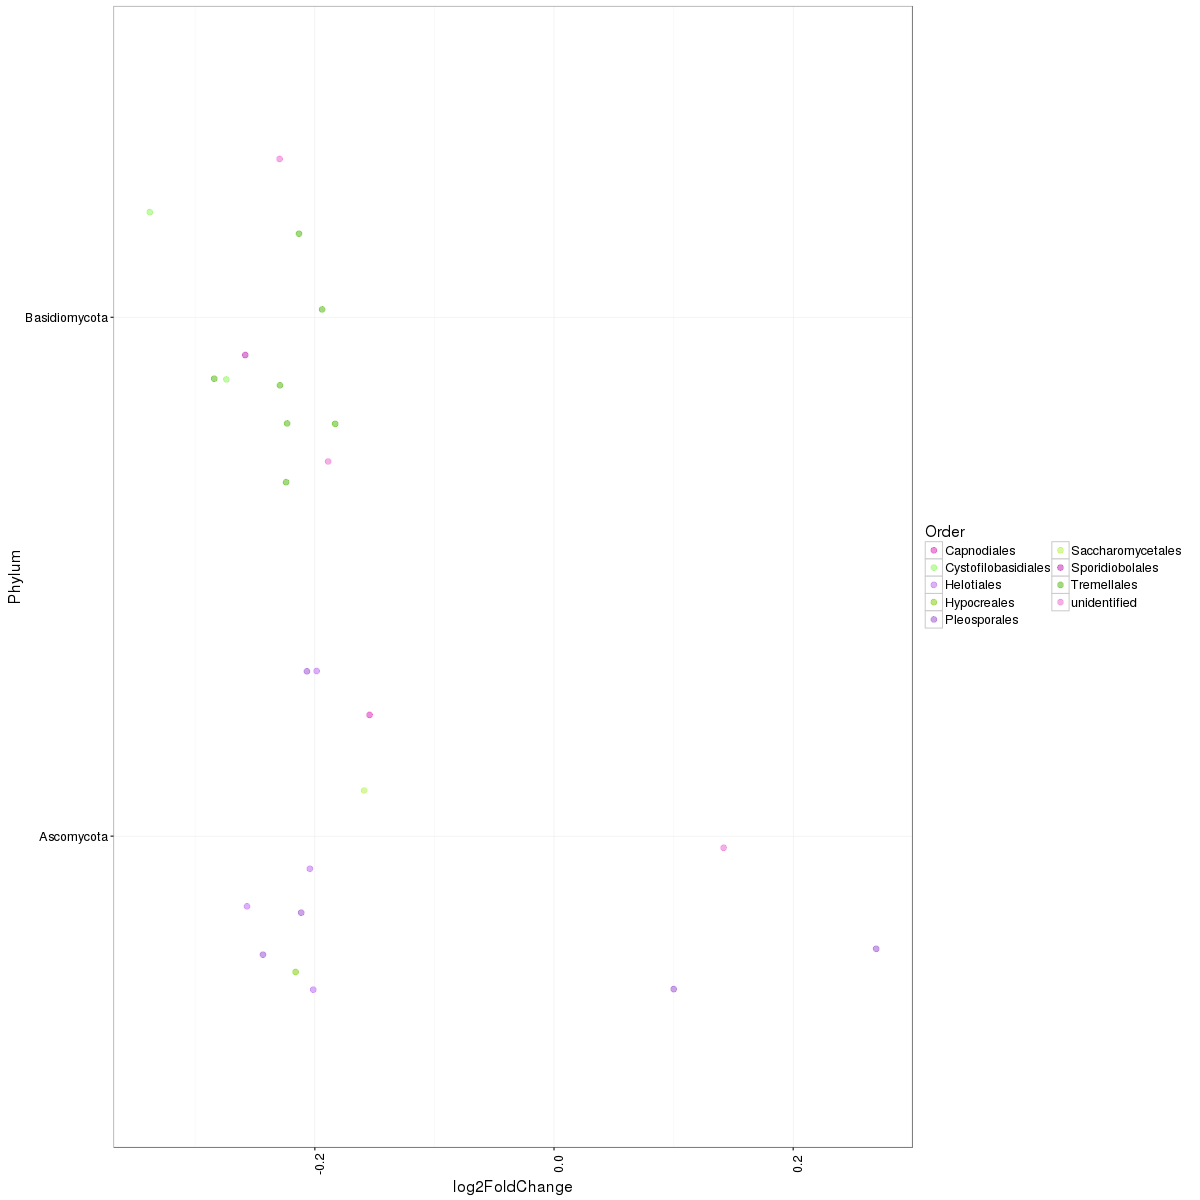

In [63]:
%%R -w 1200 -h 1200
d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)
d = filter(d, Rank2 %in% dcounts.filt$Rank2)

p = ggplot(d, aes(log2FoldChange, Rank2))
p = p + geom_jitter(aes(color = Rank4), size = 2.5, height = 0.8, alpha = 0.5)
#p = p + facet_wrap(~Rank2, scales = 'free_y')
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum") + theme_bw()

p = p + guides(color=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_color_manual(values = colors.1) 
p

In [64]:
%%R
ggsave(plot = p, filename = 'data/figs/l2fc_phylum_class.jpg', height = 14, width = 20)

In [65]:
%%R -w 600 -h 2000


phyla = unique((d.counts.filt$Rank2))

d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)

plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

   p = ggplot(plot.d, aes(as.numeric(log2FoldChange), Rank3))
    p = p + geom_point(aes(color = Resp_status))
    p = p + scale_colour_discrete((name="Responder Status"))
    p = p + ylab("Class")
    p = p + theme_bw()
    p = p + xlim(-4, 6)
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9), axis.text.y  = element_text(angle=60, vjust=0.5, size=8)) 

        p = p + ggtitle(r)


    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))


Error in unique((d.counts.filt$Rank2)) : object 'd.counts.filt' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in unique((d.counts.filt$Rank2)) : object 'd.counts.filt' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [66]:
%%R -w 600 -h 2000


phyla = unique((d.counts.filt$Rank2))

d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)

plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

   p = ggplot(plot.d, aes(as.numeric(log2FoldChange), Rank3, fill = Rank4))
    p = p + geom_point()
    p = p + scale_colour_discrete((name="Responder Status"))
    p = p + ylab("Class")
    p = p + theme_bw()
    p = p + xlim(-4, 6)
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9), axis.text.x  = element_text(angle=90, vjust=0.5, size=10)) 

        p = p + ggtitle(r)


    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))


Error in unique((d.counts.filt$Rank2)) : object 'd.counts.filt' not found
